## MNIST를 이용해 MLP 설계

퍼셉트론이 지니고 있는 한계점을 극복하기 위해 여러 layer를 쌓아올린 MLP가 등장하였다.MLP(Multi Layers Perceptron)은 Hidden layer를 넣었다.

In [1]:
#1. 필요한 모듈 import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
#2. 딥러닝 모델을 설계할 때 활용하는 cuda 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else :
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version : ', torch.__version__, '  Device : ', DEVICE)

Using PyTorch version :  1.8.0   Device :  cuda:0


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

BATCH_SIZE : MLP 모델을 학습할 때 필요한 데이터 개수의 단위<br>
데이터를 32개씩 쪼개서 전체 데이터를 학습함 -> mini_batch <br>
EPOCHS : mini_batch의 데이터 갯수를 정해주면 Iteration은 전체 데이터 개수에서 1개의 mini_batch를 구성하고 있는 데이터 개수를 나눠준 몫 만큼 Iteration 진행

전체 데이터 1만개
1000개의 데이터를 이용해 mini_batch를 만들면 한 epoch 당 10개의 Iteration을 만든다.

In [4]:
train = datasets.MNIST(root='C:/Users/HeoJiHae/Desktop/허지혜/파이썬딥러닝파이토치/data',train=True, download=True,
                      transform=transforms.ToTensor())
test = datasets.MNIST(root='C:/Users/HeoJiHae/Desktop/허지혜/파이썬딥러닝파이토치/data',train=False,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=BATCH_SIZE,
                                           shuffle=False)

In [5]:
for (X_train, y_train) in train_loader :
    print("X_train", X_train.shape, "y_train", y_train.shape)
    break

X_train torch.Size([32, 1, 28, 28]) y_train torch.Size([32])


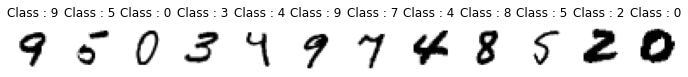

In [6]:
#3. 데이터 확인하기
pltsize = 1

plt.figure(figsize=(12 * pltsize, pltsize))
for i in range(12):
    plt.subplot(1, 12, i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap='gray_r')
    plt.title("Class : " + str(y_train[i].item()))

In [7]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [8]:
#5. Optimizer, Loss Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#https://codedragon.tistory.com/9466
# optimizer의 관성을 나타내는 momentum
# 관성의 방향을 고려해 진동과 폭을 줄이는 효과를 나타낸다.
# momentum을 설정해주므로써 정확도를 개선할 수 있다.
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [37]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): #(1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #(2)
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #(3)
        optimizer.step() #(4)
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

(1): train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 Mini-batch 단위로 묶여 저장되어 있다. 해당 train_loader 내에 Mini-batch 단위로 저장된 데이터를 순서대로 이용하여 MLP 모형을 학습을 시킨다.

(2) -> (3) -> (4) : 
     예전에 계산했던 loss의 gradient 값이 optimizer에 할당되어 있기 때문에 optimizer의 Gradient를 초기화한다.
     loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당한다.
     각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값을 업데이트한다.

In [23]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #(1)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #(2)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

(1) : MLP 모델을 평가하는 단계에서 Gradient를 통해 파라미터 값이 업데이트 되는 현상을 방지하기 위해 no_grad() 메서드를 이용해 Gradient의 흐름을 억제한다.

(2) : MLP 모델의 Output 값은 크기가 10인 벡터값이다. 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단한다.

In [40]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000(0%)] Train Loss : 0.224550
Train Epoch : 1 [6400/60000(11%)] Train Loss : 0.110952
Train Epoch : 1 [12800/60000(21%)] Train Loss : 0.265875
Train Epoch : 1 [19200/60000(32%)] Train Loss : 0.192227
Train Epoch : 1 [25600/60000(43%)] Train Loss : 0.182140
Train Epoch : 1 [32000/60000(53%)] Train Loss : 0.108630
Train Epoch : 1 [38400/60000(64%)] Train Loss : 0.122011
Train Epoch : 1 [44800/60000(75%)] Train Loss : 0.103275
Train Epoch : 1 [51200/60000(85%)] Train Loss : 0.177801
Train Epoch : 1 [57600/60000(96%)] Train Loss : 0.164235
|n[EPOCH :1], Test Loss : 0.0067, Test Accuracy : 93.89 
Train Epoch : 2 [0/60000(0%)] Train Loss : 0.063531
Train Epoch : 2 [6400/60000(11%)] Train Loss : 0.130379
Train Epoch : 2 [12800/60000(21%)] Train Loss : 0.090625
Train Epoch : 2 [19200/60000(32%)] Train Loss : 0.200581
Train Epoch : 2 [25600/60000(43%)] Train Loss : 0.493169
Train Epoch : 2 [32000/60000(53%)] Train Loss : 0.314043
Train Epoch : 2 [38400/60000(64%)] Train Lo